In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import math
import dask
import glob
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
from dask.distributed import Client, LocalCluster
if __name__ == "__main__":
    cluster=LocalCluster(host="tcp://127.0.0.1:2472",dashboard_address="127.0.0.1:2482",n_workers=4)
    client = Client(cluster)

In [3]:
x = xr.open_mfdataset('../FRONT_FILES/native/seasonal/ERA5_seasonal_fronts_native.nc').__xarray_dataarray_variable__[1:-2]

In [4]:
day_zero = x.sel(time=slice('2015-01-01', '2017-12-31'))
day_zero = day_zero.groupby(day_zero.time.dt.season).mean(dim='time')
ref = x.groupby(x.time.dt.season).mean(dim='time')

In [5]:
anom = day_zero - ref
levels = np.linspace(-0.1,0.1,101)

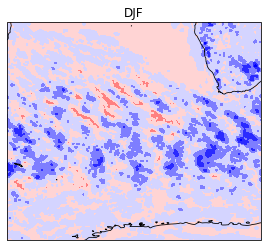

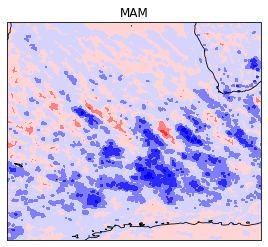

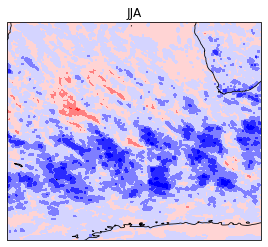

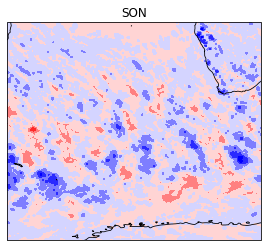

In [6]:
for seas in ['DJF','MAM','JJA','SON']:
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=0.8)
    a = ax.contourf(anom.lon.values,anom.lat.values,anom.sel(season = seas).values, cmap = 'bwr_r', vmin = -6, vmax = 6)
    for c in a.collections:
        c.set_edgecolor("face")
    plt.title(str(seas))
    #plt.colorbar(a)
    plt.savefig('../FRONT_OUT/D0_anom_'+str(seas)+".png")
    plt.savefig('../FRONT_OUT/D0_anom_'+str(seas)+".pdf")
    plt.show()

<ipython-input-7-99f7d07c3014>:1: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(a,orientation = 'horizontal')


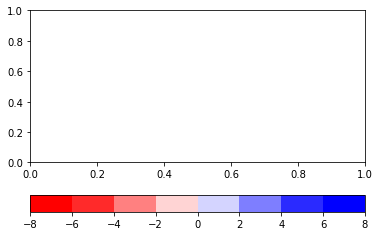

In [7]:
plt.colorbar(a,orientation = 'horizontal')
plt.savefig('../FRONT_OUT/D0_anom_cbar.pdf')
plt.show()

In [8]:
x = x.sel(lat=-35).sel(lon=17)

In [9]:
D0 = x.sel(time=slice('2015-01-01', '2017-12-31'))

In [10]:
#this is just to ensure the scatter points in the next point do not overwrite each other
y = list(D0.round(1).values)
check = []
check2 = []
new = []
for i in y:
    if i not in check:
        check.append(i)
        new.append(.01)
    elif i not in check2:
        new.append(.02)
        check2.append(i)
    else:
        new.append(.03)

In [11]:
new = xr.DataArray(new,dims=("time"),coords={"time":D0.time.values})

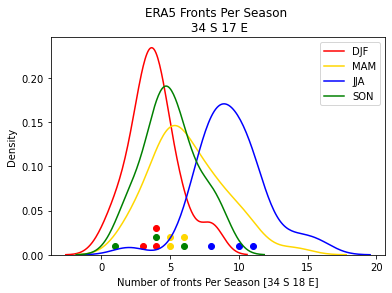

In [14]:
plt.figure()
for seas,col in zip(['DJF','MAM','JJA','SON'],['red','gold','blue','green']):
    sns.kdeplot(x.where(x.time.dt.season == seas).dropna(dim='time',how='all'),color=col,label =str(seas))
    plt.scatter(x = D0.where(D0.time.dt.season == seas).dropna(dim='time',how='all'),y = new.where(new.time.dt.season == seas).dropna(dim='time',how='all') , color=col)

plt.legend()
plt.xlabel('Number of fronts Per Season [34 S 18 E]')
plt.title('ERA5 Fronts Per Season \n 34 S 17 E')
plt.savefig('../FRONT_OUT/D0_kde_plot.png')
plt.savefig('../FRONT_OUT/D0_kde_plot.pdf')

In [13]:
client.close()